# Noise transformation
The purpose of this notebook is to empirically confirm the theoretical formulae on the transformation of noise passing from polar to Cartesian coordinates.

To perform the check, we proceed as follows:

1. we assume to acquire 100,000 different measurements. Thus, we generate 100,000 different values for magnitude and phase for a specific measuremente - without loss of generality, either current or voltage
2. we then add Gaussian noise to the measurements in polar coordinates,
3. we transform the noisy measurement into Cartesian coordinates,
4. finally, we extract the noise in Cartesian coordinate and we normalize it using its theoretical variance. 

We want to see that the normalized distribution is Gaussian and that our standardization makes the noise normally distributed with unit standard deviation.

Interestingly, and coherently with what assessed in previous works, we can appreciate how more accurate phase measurements lead to minor discrepancy from a Gaussian distribution. This can be seen by setting `theta_sd` to 0.0001 and 0.01.

# Setup

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [3]:
samples = 100000
v_range = (0.8, 1.2)
theta_range = (0, 2 * np.pi)
v_sd = 0.0001
theta_sd = 0.01

In [4]:
np.random.seed(11)

v = np.random.uniform(low=v_range[0], high=v_range[1], size=samples)
theta =np.random.uniform(low=theta_range[0], high=theta_range[1], size=samples)
noise_free_measurements = v * np.exp(1j * theta)

# Add noise in polar coordinates
We add noise in polar coordinate and we transform back to Cartesian. Then, we extract the noise by exploiting the knowledge of the real, noise-free values. 

In [5]:
np.random.seed(11)

v_noise = np.random.normal(0, v_sd, samples)
theta_noise = np.random.normal(0, theta_sd, samples)
noisy_v = v + v_noise
noisy_theta = theta + theta_noise
noisy_measurement = noisy_v * np.exp(1j * noisy_theta)

noise = noisy_measurement - noise_free_measurements

# Check noise distribution
At first, we naively try to check the distribution of the noise in Cartesian coordinates without any further transformation.

In [6]:
def plot_distribution(real_data, imag_data, normalize_dist=False):
    fig, ax = plt.subplots(2, 2)
    ax[0, 0].set_title('Re(noise) - QQ plots')
    sm.qqplot(real_data, line='45', ax=ax[0, 0], fit=normalize_dist, marker='x', markersize=2)
    ax[0, 1].set_title('Im(noise) - QQ plots')
    sm.qqplot(imag_data, line='45', ax=ax[0, 1], fit=normalize_dist, marker='x', markersize=2)
    ax[1, 0].set_title('Re(noise)')
    ax[1, 0].hist(real_data, bins=100)
    ax[1, 1].set_title('Im(noise)')
    ax[1, 1].hist(imag_data, bins=100)
    plt.tight_layout()
    plt.show()

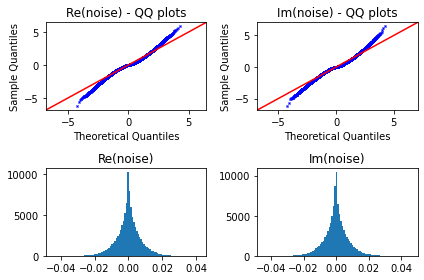

In [7]:
plot_distribution(np.real(noise), np.imag(noise), normalize_dist=True)

# Check normalized noise distribution
We should remember that the noise in Cartesian coordinates is not IID. In fact, the variance depends on the real value of each sample. 

Thus, in order to check for the noise distribution, we need to normalize each sample for its standard deviation and then check if the distribution of real and imaginary parts are Gaussian.

In [8]:
v_var = v_sd ** 2
theta_var = theta_sd ** 2

#real_var = np.cos(theta)**2 * v_var + v**2 * np.sin(theta)**2 * theta_var
#imag_var = np.sin(theta)**2 * v_var + v**2 * np.cos(theta)**2 * theta_var

real_var = v**2 * np.exp(-2*theta_var) * (np.cos(theta)**2 * (np.cosh(2*theta_var) - np.cosh(theta_var)) + np.sin(theta)**2 * (np.sinh(2*theta_var) - np.sinh(theta_var))) + v_var * np.exp(-2*theta_var) * (np.cos(theta)**2 * (2*np.cosh(2*theta_var) - np.cosh(theta_var)) + np.sin(theta)**2 * (2*np.sinh(2*theta_var) - np.sinh(theta_var)))
imag_var = v**2 * np.exp(-2*theta_var) * (np.sin(theta)**2 * (np.cosh(2*theta_var) - np.cosh(theta_var)) + np.cos(theta)**2 * (np.sinh(2*theta_var) - np.sinh(theta_var))) + v_var * np.exp(-2*theta_var) * (np.sin(theta)**2 * (2*np.cosh(2*theta_var) - np.cosh(theta_var)) + np.cos(theta)**2 * (2*np.sinh(2*theta_var) - np.sinh(theta_var)))

real_sd, imag_sd = np.sqrt(real_var), np.sqrt(imag_var)

real_norm = np.real(noise) / real_sd
imag_norm = np.imag(noise) / imag_sd

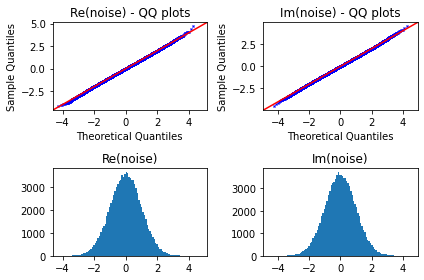

In [9]:
plot_distribution(real_norm, imag_norm)

# Real and imag part covariance
Our theoretical model also predict a non-zero covariance between the real and imaginary parts of the noise. 
Let us check this conclusion as well.

In [10]:
np.cov(real_norm, imag_norm)

array([[ 0.99294444, -0.00550161],
       [-0.00550161,  0.99123969]])

In [11]:
np.min(real_var), np.max(real_var)

(1.9833084666165592e-08, 0.0001439288881692769)